In this notebook, I'm going to create a model to classify hate speeches, which are public speeches that express hate or encourage violence towards a person or group based on something such as race, religion, sex, or sexual orientation.

Steps to classify hate speeches

- Preprocess the text dataset
- Conver text data into tokens
- Build and train ML
- Test the model
- Sae and use it for later cases

In [7]:
dataset = 'https://raw.githubusercontent.com/laxmimerit/hate_speech_dataset/master/data.csv'

# 1. Import packages and collect data

In [ ]:
# Import preprocessing related packages
!python -m spacy download en_core_web_lg
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection  import train_test_split
import preprocess_kgptalkie as ps

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #pad sequence do the padding things if the length of the tweets are short.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import  plot_confusion_matrix


In [8]:
df = pd.read_csv(dataset, index_col= 0)

In [9]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


For our target variable, which is 'class', we have 3 classes as follow:

- 0: hate speech
- 1: offensive speech
- 2: neither

Other variables in the dataset:

- count: number of crowdfloer (CF) users who coded each tweet
- hate_speech: number of CF users who judged the tweet to be a hate speech
- offensive_speech: number of CF users who judged the tweet to be offensive.
- neither: number of CF users who judged the tweet to be neither hate speech nor offensive.

In [10]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

This is an imbalanced dataset

# 2. Prepare the dataset

## 2.1. Balance the dataset

In [13]:
#Balance the dataset

vc = df['class'].value_counts()
index = list(vc.index)
count = min(vc.values)
count

1430

In [14]:
df_bal = pd.DataFrame()
for i in index:
  temp = df[df['class'] == i].sample(count)
  df_bal = df_bal.append(temp, ignore_index = True)

In [15]:
df_bal

,count,hate_speech,offensive_language,neither,class,tweet
0,3,1,2,0,1,Man that nigga Courage always bein a bitch. HI...
1,3,0,3,0,1,Bitch just sucked my dick and tried to give me...
2,6,0,6,0,1,Sone of y'all bitches need morning glory milk ...
3,3,0,3,0,1,"I love bad bitches it my fucking hobby, and ye..."
4,3,0,3,0,1,RT @MLPerkinsJr: Overtime bitches.
...,...,...,...,...,...,...
4285,3,3,0,0,0,"...you're white, aren't you? *rolls eyes* RT @..."
4286,3,3,0,0,0,"RT @useemitch: 1, 2, 3, 4... how many niggers ..."
4287,3,2,1,0,0,"RT @jerrilyn71: ""@HistoryGoon: hey dicklicker!..."
4288,3,3,0,0,0,I hate the ghetto trash at the special school ...


In [16]:
df_bal['class'].value_counts()

2    1430
1    1430
0    1430
Name: class, dtype: int64

## 2.2. Preprocess the text data

In [18]:
df_bal['tweet'] = df_bal['tweet'].apply(lambda x: get_clean(x))

In [19]:
df_bal['tweet'].head(10)

0    man that nigga courage always bein a bitch hit...
1    bitch just sucked my dick and tried to give me...
2    sone of yall bitches need morning glory milk b...
3    i love bad bitches it my fucking hobby and yea...
4                 retweet mlperkinsjr overtime bitches
5     do not worry about the bitches i use to fuck wit
6    she gotta shape up her pussy lips though postp...
7    chanelisabeth emmasayshai icanhashtaghoweveriw...
8    retweet thad castie a milf is a sexy ass mom o...
9    kazatta if yo girl let them in she a hoeshe be...
Name: tweet, dtype: object

Now the tweets are ready to be tokenized

## 2.3. Text Tokenization

In [24]:
text = df_bal['tweet'].tolist()

Let's create a tokenizer and let it learn on our tweets

In [25]:
token = Tokenizer()
token.fit_on_texts(text)

In [26]:
#Preview some of the tokens
token.word_counts

OrderedDict([('man', 100),
             ('that', 611),
             ('nigga', 210),
             ('courage', 1),
             ('always', 47),
             ('bein', 2),
             ('a', 1566),
             ('bitch', 809),
             ('hit', 20),
             ('dat', 45),
             ('shit', 167),
             ('lil', 35),
             ('just', 257),
             ('sucked', 5),
             ('my', 601),
             ('dick', 35),
             ('and', 795),
             ('tried', 14),
             ('to', 971),
             ('give', 41),
             ('me', 397),
             ('sugar', 4),
             ('get', 213),
             ('out', 323),
             ('sone', 1),
             ('of', 539),
             ('yall', 95),
             ('bitches', 254),
             ('need', 61),
             ('morning', 23),
             ('glory', 1),
             ('milk', 4),
             ('baths', 1),
             ('i', 1458),
             ('love', 112),
             ('bad', 63),
             ('it', 

In [27]:
len(token.word_counts)

11837

In [28]:
x = ['i love you']
token.texts_to_sequences(x)

[[2, 78, 5]]

In [29]:
x = ['i love you so much']
token.texts_to_sequences(x)

[[2, 78, 5, 30, 177]]

In [30]:
vocab_size = len(token.word_counts) + 1

In [31]:
encoded_text = token.texts_to_sequences(text)

In [32]:
for i in range(5):
  print(encoded_text[i])

[83, 11, 43, 3870, 169, 2291, 1, 8, 326, 179, 55, 213, 43]
[8, 31, 1101, 12, 214, 9, 454, 6, 189, 19, 1332, 8, 39, 27]
[3871, 14, 89, 32, 130, 296, 3872, 1333, 3873]
[2, 78, 125, 32, 15, 12, 58, 3874, 9, 227, 35, 26, 17, 33, 3875, 16, 1, 58, 3876]
[4, 3877, 3878, 32]


We can see the length of each tweet are not consistent.
We still have to choose a fixed length for our DL model.

In [33]:
max_length = 120
X = pad_sequences(encoded_text, max_length, padding= 'post') #add paddings after the text

In [34]:
print(X)

[[   83    11    43 ...     0     0     0]
 [    8    31  1101 ...     0     0     0]
 [ 3871    14    89 ...     0     0     0]
 ...
 [    4 11830 11831 ...     0     0     0]
 [    2    91     3 ...     0     0     0]
 [11837    61   749 ...     0     0     0]]


In [35]:
X.shape

(4290, 120)

#3. Model building

## 3.1. Train test split

In [42]:
# Create one-hot encoded vectors for y
y = np_utils.to_categorical(df_bal['class'])

In [43]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [44]:
y.shape

(4290, 3)

In [45]:
X_train, X_test, y_train ,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0, stratify = y)

X_train.shape,X_test.shape

((3432, 120), (858, 120))

## 3.2. Build the model

In [52]:
vec_size = 300
model = Sequential()
# Embedding layer takes in encoded tweet with dim = vocab_size(120), and output a vector with vec_size = 300
model.add(Embedding(vocab_size, vec_size, input_length= 120))

model.add(Conv1D(32,2, activation= 'relu'))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3,activation='softmax'))


In [53]:
model.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train,y_train,epochs = 5, validation_data = (X_test,y_test))

Epoch 1/5
108/108 [==============================] - 5s 39ms/step - loss: 1.0200 - accuracy: 0.5055 - val_loss: 0.7894 - val_accuracy: 0.7413
Epoch 2/5
108/108 [==============================] - 4s 37ms/step - loss: 0.5604 - accuracy: 0.8065 - val_loss: 0.5325 - val_accuracy: 0.7692
Epoch 3/5
108/108 [==============================] - 4s 38ms/step - loss: 0.3361 - accuracy: 0.8718 - val_loss: 0.5451 - val_accuracy: 0.7681
Epoch 4/5
108/108 [==============================] - 4s 38ms/step - loss: 0.1884 - accuracy: 0.9382 - val_loss: 0.6126 - val_accuracy: 0.7564
Epoch 5/5
108/108 [==============================] - 4s 38ms/step - loss: 0.0919 - accuracy: 0.9723 - val_loss: 0.7107 - val_accuracy: 0.7506


## 3.3. Model testing

In [57]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

In [58]:
y_pred

array([2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2,
       1, 0, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 1,
       1, 0, 2, 2, 2, 1, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1,
       2, 0, 2, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 1, 2, 0, 1,
       2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0,
       1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 0, 2, 0, 1, 0,
       0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 1, 2,
       2, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0,
       0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2,
       0, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2,
       2, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0, 1, 1, 0,

In [59]:
y_test = np.argmax(y_test, axis=-1)
y_test

array([2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2,
       1, 1, 0, 2, 0, 2, 1, 1, 2, 1, 2, 0, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1,
       1, 0, 2, 2, 2, 0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0,
       1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 2,
       0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 1,
       2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 2,
       2, 1, 0, 0, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1,
       2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 1,
       2, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 1, 0, 2, 0, 1, 2, 1, 2, 0, 1,
       2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 0,
       0, 2, 1, 1, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 2,
       0, 2, 0, 1, 1, 2, 0, 2, 0, 2, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2,
       2, 0, 0, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0,

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f086a151890>)

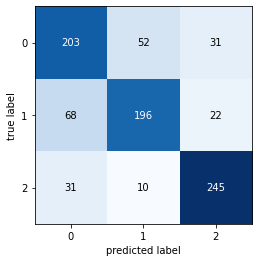

In [60]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred))

In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       286
           1       0.76      0.69      0.72       286
           2       0.82      0.86      0.84       286

    accuracy                           0.75       858
   macro avg       0.75      0.75      0.75       858
weighted avg       0.75      0.75      0.75       858



## 3.4. Model testing with custom data

In [79]:
x = 'hey bitch!'

Let's create a function to make our testings faster and more convenient

In [80]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, max_length, padding = 'post')
  return x

In [81]:
get_encoded(x)

array([[265,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [82]:
np.argmax(model.predict(get_encoded(x)),axis = -1)

array([1])

This is clearly a offensive a speech.

# 4. Store the model

In [83]:
import pickle

In [84]:
model.save('model_hate_speech.h5')
pickle.dump(token, open('token.pkl','wb'))